<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-GY9123_DL/blob/main/Project/Yolov1/yolov1train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## YOLO train notebook

The notebook is offered to help us to train the model. We train the YOLO net on 5,000 pictures and test it on 100 pictures. 

Before you train, things you need to prepare


*   dataset.py
*   loss.py
*   model.py
*   utils.py
*   train.csv







In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from utils import (
  non_max_suppression,
  mean_average_precision,
  intersection_over_union,
  cellboxes_to_boxes,
  get_bboxes,
  plot_image,
  save_checkpoint,
  load_checkpoint,
)

In [ ]:
"""
Main file for training Yolo model on Pascal VOC dataset
"""

import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import Yolov1
from dataset import VOCDataset
from loss import YoloLoss

In [ ]:
seed = 123
torch.manual_seed(seed)

# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 60
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "yolo_model.pth.tar"
IMG_DIR = "gdrive/MyDrive/2021_DL_Proj/data/images"
LABEL_DIR = "gdrive/MyDrive/2021_DL_Proj/data/labels"
#gdrive/MyDrive/2021_DL_Proj/data/

In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [ ]:
def train_fn(train_loader, model, optimizer, loss_fn,loss_avg):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    loss_avg.append(sum(mean_loss)/len(mean_loss))
    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [ ]:
def evaluate_fn(evaluate_loader, model, loss_fn,loss_avg):
    loop = tqdm(evaluate_loader, leave=True)
    mean_loss = []
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()

        # update progress bar
        #loop.set_postfix(loss=loss.item())

    loss_avg.append(sum(mean_loss)/len(mean_loss))
    print(f"evaluation loss was {sum(mean_loss)/len(mean_loss)}")

In [ ]:
train_acc = []
evaluate_acc = []
train_loss = []
evaluate_loss = []

In [ ]:
def main():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "train.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    evaluate_dataset = VOCDataset(
        "evaluation.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    """
    test_dataset = VOCDataset(
        "data/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )
    """

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    evaluate_loader = DataLoader(
        dataset=evaluate_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )
    """
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )
    """

    for epoch in range(EPOCHS):

        train_pred_boxes, train_target_boxes = get_bboxes(          
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        train_mean_avg_prec = mean_average_precision(
            train_pred_boxes, train_target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        train_acc.append(train_mean_avg_prec)
        print(f"Train mAP: {train_mean_avg_prec}")

        evaluate_pred_boxes, evaluate_target_boxes = get_bboxes(          
            evaluate_loader, model, iou_threshold=0.5, threshold=0.4
        )

        evaluate_mean_avg_prec = mean_average_precision(
            evaluate_pred_boxes, evaluate_target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        evaluate_acc.append(evaluate_mean_avg_prec)
        print(f"evaluate mAP: {evaluate_mean_avg_prec}")

        if train_mean_avg_prec > 0.85:
           checkpoint = {
               "state_dict": model.state_dict(),
               "optimizer": optimizer.state_dict(),
           }
           save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
           import time
           time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn,train_loss)
        evaluate_fn(evaluate_loader, model, loss_fn,evaluate_loss)

In [ ]:
if __name__ == "__main__":
    main()

Train mAP: 0.0


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.0


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 301.6262715657552


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]

evaluation loss was 197.88702519734701


Train mAP: 0.0013266588794067502


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.000756629859097302


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 173.92573322393955


100%|██████████| 12/12 [00:02<00:00,  4.52it/s]

evaluation loss was 188.47637557983398


Train mAP: 0.0058113220147788525


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.007249116897583008


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 156.1191767179049


100%|██████████| 12/12 [00:02<00:00,  4.39it/s]

evaluation loss was 178.39510854085287


Train mAP: 0.007920127362012863


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.009035103023052216


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 145.1806362836789


100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

evaluation loss was 177.80660247802734


Train mAP: 0.016353439539670944


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.00422343285754323


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 136.26405838208322


100%|██████████| 12/12 [00:02<00:00,  4.34it/s]

evaluation loss was 173.90736389160156


Train mAP: 0.02429228648543358


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.009100480936467648


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 127.944535108713


100%|██████████| 12/12 [00:02<00:00,  4.39it/s]

evaluation loss was 181.04926045735678


Train mAP: 0.02177066169679165


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.0014875988708809018


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 120.14235296004858


100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

evaluation loss was 179.71385192871094


Train mAP: 0.05366344004869461


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.013816277496516705


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 111.56467292247675


100%|██████████| 12/12 [00:02<00:00,  4.64it/s]

evaluation loss was 179.348970413208


Train mAP: 0.0907210111618042


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.010965648107230663


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 103.39921325292343


100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

evaluation loss was 172.1696917215983


Train mAP: 0.15965810418128967


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.005059191025793552


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 96.8591174468016


100%|██████████| 12/12 [00:02<00:00,  4.41it/s]

evaluation loss was 178.14365768432617


Train mAP: 0.18655706942081451


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.009388317354023457


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 91.21903034356924


100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

evaluation loss was 173.60181935628256


Train mAP: 0.2831258177757263


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.012016568332910538


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 85.55756820776524


100%|██████████| 12/12 [00:02<00:00,  4.39it/s]

evaluation loss was 173.84233220418295


Train mAP: 0.2600667476654053


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.014558373019099236


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 81.44549106940245


100%|██████████| 12/12 [00:02<00:00,  4.42it/s]

evaluation loss was 176.23837025960287


Train mAP: 0.3874925673007965


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.020062310621142387


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 76.0236479196793


100%|██████████| 12/12 [00:02<00:00,  4.51it/s]

evaluation loss was 173.3470033009847


Train mAP: 0.4562526345252991


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.013137927278876305


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 74.08131535847981


100%|██████████| 12/12 [00:02<00:00,  4.43it/s]

evaluation loss was 173.6783905029297


Train mAP: 0.5070830583572388


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.01782146468758583


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 71.22583764638657


100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

evaluation loss was 165.07690938313803


Train mAP: 0.5076436400413513


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.01913265883922577


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 69.47383307187985


100%|██████████| 12/12 [00:02<00:00,  4.48it/s]

evaluation loss was 171.08139038085938


Train mAP: 0.5920332074165344


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.011449448764324188


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 61.60505524659768


100%|██████████| 12/12 [00:02<00:00,  4.39it/s]

evaluation loss was 169.8681786855062


Train mAP: 0.5921249389648438


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.013815773651003838


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 57.739611882429855


100%|██████████| 12/12 [00:02<00:00,  4.22it/s]

evaluation loss was 173.76848602294922


Train mAP: 0.6495732665061951


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.021428201347589493


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 56.77125861094548


100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

evaluation loss was 165.16637102762857


Train mAP: 0.639700710773468


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.017114128917455673


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 55.942807154777725


100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

evaluation loss was 167.82366053263345


Train mAP: 0.705731987953186


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.0221437718719244


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 57.166182444645806


100%|██████████| 12/12 [00:02<00:00,  4.37it/s]

evaluation loss was 169.3344472249349


Train mAP: 0.7134051322937012


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.017858188599348068


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 50.837084654049995


100%|██████████| 12/12 [00:02<00:00,  4.43it/s]

evaluation loss was 168.4200127919515


Train mAP: 0.6894751787185669


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.023798834532499313


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 48.74591274139209


100%|██████████| 12/12 [00:02<00:00,  4.24it/s]

evaluation loss was 169.97918574015299


Train mAP: 0.7421892285346985


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.012427465990185738


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 47.76620918665177


100%|██████████| 12/12 [00:02<00:00,  4.41it/s]

evaluation loss was 168.97873306274414


Train mAP: 0.7433429956436157


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.015865998342633247


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 45.76720613699693


100%|██████████| 12/12 [00:02<00:00,  4.39it/s]

evaluation loss was 162.56248982747397


Train mAP: 0.7673690319061279


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.024106284603476524


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 41.93896656769972


100%|██████████| 12/12 [00:02<00:00,  4.16it/s]

evaluation loss was 174.1473045349121


Train mAP: 0.7362248301506042


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.022178996354341507


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 41.49668099941351


100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

evaluation loss was 167.00163714090982


Train mAP: 0.7595611810684204


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.024118836969137192


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 39.720400260044975


100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

evaluation loss was 162.46147918701172


Train mAP: 0.7812288999557495


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.03532169386744499


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 41.94903191542014


100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

evaluation loss was 169.7095489501953


Train mAP: 0.7378894686698914


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.026268210262060165


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 40.31638441941677


100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

evaluation loss was 164.11765162150064


Train mAP: 0.7743942737579346


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.031495776027441025


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 37.41682449976603


100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

evaluation loss was 164.2674961090088


Train mAP: 0.7946135401725769


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.020883647724986076


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 35.4396501443325


100%|██████████| 12/12 [00:02<00:00,  4.50it/s]

evaluation loss was 170.82103411356607


Train mAP: 0.7642258405685425


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.0158581230789423


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 34.64964387355707


100%|██████████| 12/12 [00:02<00:00,  4.42it/s]

evaluation loss was 164.87591171264648


Train mAP: 0.7919324636459351


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.017550697550177574


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 33.57895332727677


100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

evaluation loss was 170.0034968058268


Train mAP: 0.8001686334609985


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.023374784737825394


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 31.752772163122128


100%|██████████| 12/12 [00:02<00:00,  4.37it/s]

evaluation loss was 164.9698804219564


Train mAP: 0.8033605813980103


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.02078166976571083


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 32.770216996853165


100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

evaluation loss was 168.0268179575602


Train mAP: 0.799765944480896


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.020112166181206703


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 32.686597851606514


100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

evaluation loss was 162.72378412882486


Train mAP: 0.8163792490959167


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.02797793224453926


  0%|          | 0/12 [00:00<?, ?it/s]

Mean loss was 29.277310768763225


100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

evaluation loss was 164.696164449056


Train mAP: 0.8121967315673828


  0%|          | 0/312 [00:00<?, ?it/s]

evaluate mAP: 0.02072923071682453


  3%|▎         | 8/312 [00:03<02:01,  2.50it/s, loss=28.7]

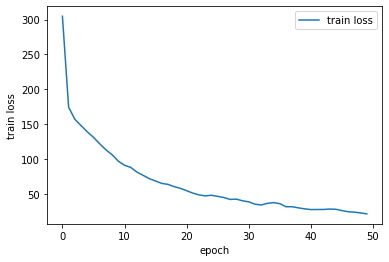

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss,label="train loss")
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.legend()
plt.show()
plt.savefig("trainloss.png")

In [ ]:
acc_first10 = acc

In [ ]:
loss_first10 = loss

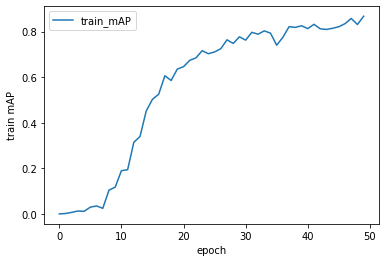

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(acc, label="train_mAP")
plt.xlabel("epoch")
plt.ylabel("train mAP")
plt.legend()
plt.show()
plt.savefig("trainmAP.png")

In [ ]:
yolomodel = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(
    yolomodel.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

load_checkpoint(torch.load(LOAD_MODEL_FILE), yolomodel, optimizer)

=> Loading checkpoint


In [ ]:
test_dataset = VOCDataset(
  "test.csv",
  transform=transform,
  img_dir=IMG_DIR,
  label_dir=LABEL_DIR,
)

test_loader = DataLoader(
  dataset=test_dataset,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
  pin_memory=PIN_MEMORY,
  shuffle=True,
  drop_last=True,
)

In [ ]:
train_data = VOCDataset(
  "train.csv",
  transform=transform,
  img_dir=IMG_DIR,
  label_dir=LABEL_DIR,
)

train_loader = DataLoader(
  dataset=train_data,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
  pin_memory=PIN_MEMORY,
  shuffle=True,
  drop_last=True,
)

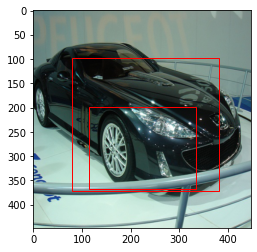

[[14.0, 0.5627654194831848, 0.5019071102142334, 0.6330217719078064, 0.48908746242523193, 0.3791249394416809], [14.0, 0.5598382949829102, 0.5150954127311707, 0.5237213373184204, 0.6762794852256775, 0.6137165427207947]]


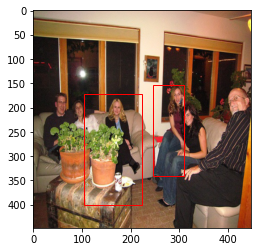

[[14.0, 0.46769338846206665, 0.3661254048347473, 0.6393832564353943, 0.2632238566875458, 0.5111937522888184], [14.0, 0.44434887170791626, 0.6212322115898132, 0.5502211451530457, 0.14342956244945526, 0.4181351065635681]]


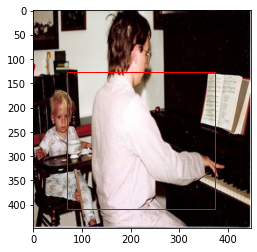

[[13.0, 0.4674316942691803, 0.4952256977558136, 0.5979709029197693, 0.6836583614349365, 0.629784107208252]]


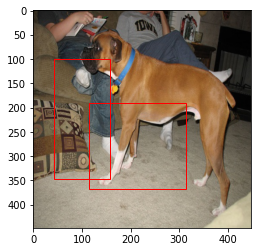

[[14.0, 0.5554155111312866, 0.2233671098947525, 0.49935272336006165, 0.2558435797691345, 0.5543456673622131], [6.0, 0.44286608695983887, 0.4789583086967468, 0.6229985952377319, 0.44844135642051697, 0.393090158700943]]


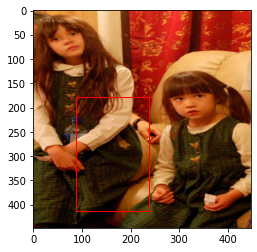

[[14.0, 0.5338366031646729, 0.36412909626960754, 0.6595872044563293, 0.3389780819416046, 0.5270429253578186]]


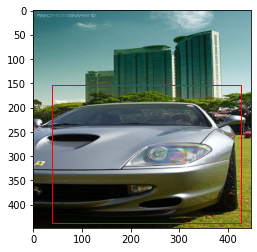

[[6.0, 0.44468241930007935, 0.5206654071807861, 0.6589156985282898, 0.8700350522994995, 0.6318891048431396]]


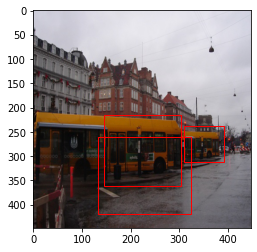

[[12.0, 0.4620206952095032, 0.7846216559410095, 0.6155439615249634, 0.18570956587791443, 0.16566655039787292], [14.0, 0.43423402309417725, 0.5011586546897888, 0.6428725123405457, 0.3574972450733185, 0.329648494720459], [14.0, 0.4243127703666687, 0.5109008550643921, 0.7592803835868835, 0.42727455496788025, 0.35153210163116455]]


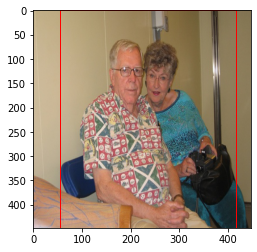

[[14.0, 0.45857101678848267, 0.5272327661514282, 0.504035472869873, 0.8058765530586243, 1.0090241432189941]]


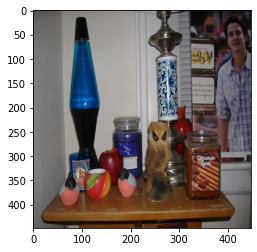

[]


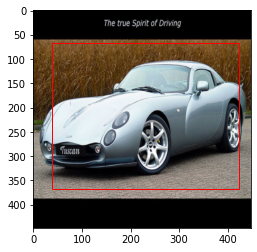

[[6.0, 0.44877752661705017, 0.5164180397987366, 0.48493701219558716, 0.8609921336174011, 0.6719769239425659]]


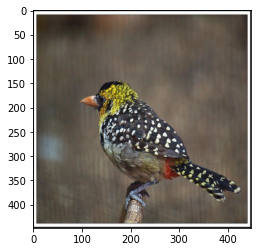

[]


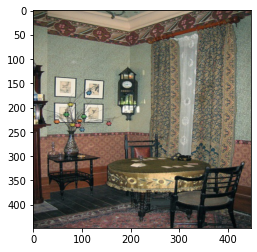

[]


In [ ]:
#count=0
for x, y in test_loader:
  # if count==8:
  #   break;
  # count+=1
  x = x.to(DEVICE)
  for idx in range(2):
      bboxes = cellboxes_to_boxes(yolomodel(x))
      bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
      plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
      print(bboxes)